In [1]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [2]:
df = pd.read_csv('sample_100_15k.csv')

In [3]:
df.head()

artist                      song_name closest_genre  \
0               Sam Cooke        Meet Me At Mary's Place         Blues   
1         Curtis Mayfield  Give Me Your Love (Love Song)         Blues   
2               Sam Cooke         Another Saturday Night         Blues   
3  Sonny Boy Williamson I       Something Going On Wrong         Blues   
4             Carole King                 Where You Lead         Blues   

                                               lyric  length_lyric  
0  A friend of mine told me one early mornin'\n(O...           290  
1  SO IN LOVE\nSO IN LOVE, YOU DO SO MANY THINGS ...           218  
2  Let me tell you 'bout a place\nSomewhere up-a ...           220  
3  (Together) We will go our way\n(Together) We w...           364  
4  Wanting you the way I do\nI only wanna be with...           166

In [4]:
eng_stopwords = stopwords.words('english')

In [5]:
def stopwords_removing(text):
     return ' '.join([word for word in text.split() if word not in eng_stopwords])

In [6]:

df['lyric_processed'] = df.lyric.map(lambda x: re.sub('[(),\.!?]', '', x))
df['lyric_processed'] = df.lyric_processed.map(lambda x: x.lower())
df['lyric_processed'] = df.lyric_processed.map(lambda x: stopwords_removing(x))
df.lyric_processed.head()

0    friend mine told one early mornin' mary's plac...
1    love love many things smiling face love everyt...
2    let tell 'bout place somewhere up-a new-york w...
3    together go way together leave day together ha...
4    wanting way wanna would go ends earth cause da...
Name: lyric_processed, dtype: object

In [7]:
long_string = ','.join(df.lyric_processed.to_list())

In [8]:
wordcloud = WordCloud(max_words=5000, contour_width=3, contour_color='steelblue', background_color='white')

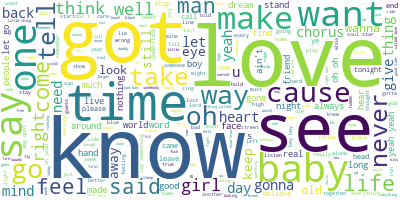

In [9]:
wordcloud.generate(long_string)
wordcloud.to_image()

In [10]:
# per genre
for genre in df.closest_genre.unique():
    print(f'{genre}')
    dt = df.query(f'closest_genre=="{genre}"')
    long_string = ','.join(dt.lyric_processed.to_list())
    wordcloud = WordCloud(max_words=5000, contour_width=3, contour_color='steelblue', background_color='white')
    wordcloud.generate(long_string)
    wordcloud.to_file(f'{genre}_5000words.png')

Blues
Country
Electronic
Folk
Hip Hop
Jazz
Metal
Pop
Punk
Reggae
Rock


In [11]:
# Prepare data for LDA Analysis
import gensim
from gensim.utils import simple_preprocess
eng_stopwords.extend(['from', 'subject', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

data = df.lyric_processed.to_list()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['friend', 'mine', 'told', 'one', 'early', 'mornin', 'mary', 'place', 'ho', 'said', 'tonight', 'there', 'gonna', 'party', 'goin', 'mary', 'place', 'ho', 'said', 'if', 'enjoy', 'real', 'nice', 'affair', 'mary', 'place', 'ho', 'make', 'business', 'right']


In [12]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)

texts = data_words

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 1), (1, 6), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 15), (12, 2), (13, 1), (14, 1), (15, 11), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 20), (22, 17), (23, 1), (24, 1), (25, 1), (26, 2), (27, 3), (28, 1), (29, 20)]


In [13]:
from pprint import pprint

In [14]:
num_topics = 20

lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

pprint(lda_model.print_topics())

[(0,
  '0.016*"night" + 0.011*"go" + 0.010*"say" + 0.008*"yeah" + 0.008*"let" + '
  '0.008*"oh" + 0.008*"good" + 0.007*"got" + 0.007*"get" + 0.006*"ll"'),
 (1,
  '0.043*"love" + 0.015*"like" + 0.014*"oh" + 0.011*"got" + 0.010*"know" + '
  '0.009*"ll" + 0.009*"say" + 0.007*"ve" + 0.006*"see" + 0.006*"never"'),
 (2,
  '0.017*"yeah" + 0.015*"baby" + 0.013*"little" + 0.013*"love" + 0.011*"night" '
  '+ 0.011*"thing" + 0.010*"like" + 0.009*"ll" + 0.009*"day" + 0.008*"take"'),
 (3,
  '0.014*"know" + 0.010*"like" + 0.009*"get" + 0.009*"one" + 0.008*"say" + '
  '0.007*"girl" + 0.007*"go" + 0.007*"never" + 0.007*"see" + 0.006*"got"'),
 (4,
  '0.014*"get" + 0.012*"got" + 0.010*"want" + 0.010*"like" + 0.009*"oh" + '
  '0.009*"love" + 0.009*"make" + 0.008*"know" + 0.008*"time" + 0.007*"ve"'),
 (5,
  '0.016*"could" + 0.015*"never" + 0.011*"like" + 0.011*"know" + 0.011*"say" + '
  '0.010*"let" + 0.009*"oh" + 0.009*"ll" + 0.009*"back" + 0.009*"get"'),
 (6,
  '0.021*"love" + 0.010*"know" + 0.009*"yeah

In [15]:
doc_lda = lda_model[corpus]

In [16]:
# Analyizing LDA model results

import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('lda_results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath+'.html')

LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.020519  0.011696       1        1  14.183909
4     -0.030800 -0.004504       2        1   8.529584
8     -0.035207  0.005666       3        1   8.501482
7     -0.030598  0.019943       4        1   6.536045
1     -0.050938  0.012487       5        1   6.516277
2     -0.022075  0.001928       6        1   6.032195
16    -0.011755  0.054161       7        1   5.163837
3      0.017407 -0.002432       8        1   4.811866
14     0.000446 -0.017946       9        1   4.627176
0     -0.004559 -0.008074      10        1   4.597931
19     0.005407 -0.005614      11        1   4.044816
15    -0.014624 -0.102454      12        1   3.784551
6     -0.025810  0.020518      13        1   3.579996
9      0.012261 -0.027770      14        1   3.565554
17     0.016885  0.025470      15        1   3.103645
12     0.020027  0.012304      16        1   2.977917
10     0.008635  0.003368      17        1   2.871407
11     0.046216  0.003854      18        1   2.686792
13     0.014257 -0.011333      19        1   2.619585
18     0.105345  0.008732      20        1   1.265436, topic_info=     Term         Freq        Total Category  logprob  loglift
77   love  1754.000000  1754.000000  Default  30.0000  30.0000
165  baby   844.000000   844.000000  Default  29.0000  29.0000
582  yeah   794.000000   794.000000  Default  28.0000  28.0000
73    let   784.000000   784.000000  Default  27.0000  27.0000
20    man   502.000000   502.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
249   can     7.311348   702.689858  Topic20  -5.4945  -0.1957
13    got     7.278740  1025.084565  Topic20  -5.4990  -0.5778
18   like     7.280477  1239.144279  Topic20  -5.4988  -0.7672
36   time     6.864553   850.079604  Topic20  -5.5576  -0.4492
17   know     6.729025  1314.392999  Topic20  -5.5775  -0.9049

[1544 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1438       1  0.683472     aaah
3198       9  0.625455    aaahh
3198      11  0.089351    aaahh
3198      18  0.178701    aaahh
9169       9  0.146895  abigail
...      ...       ...      ...
11232      1  0.017177      yoy
11232     15  0.961902      yoy
10811      7  0.854328       yu
11355      5  0.821296       ½d
11356      5  0.773750      ½re

[6386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 9, 8, 2, 3, 17, 4, 15, 1, 20, 16, 7, 10, 18, 13, 11, 12, 14, 19])